# Using Nested-Pandas with Astronomical Spectra

In Astronomy, a spectrum is a measurement (or combination of measurements) of an object that shows the intensity of light emitted over a range of energies. In this tutorial, we'll walk through a simple example of working with spectra from the Sloan Digital Sky Survey (SDSS), in particular showing how it can be represented as a `NestedFrame`.

First, we'll use `astroquery` and `astropy` to download a handful of spectra from SDSS:

In [3]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
import nested_pandas as npd

# Query SDSS for a set of objects with spectra
pos = coords.SkyCoord("0h8m10.63s +14d50m23.3s", frame="icrs")
xid = SDSS.query_region(pos, radius=3 * u.arcmin, spectro=True)
xid_ndf = npd.NestedFrame(xid.to_pandas())
xid_ndf

,ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d
0,2.076662,14.843455,1237652943176204410,1739,301,3,316,-0.000464,6112,56191,560,6881654266119084032,v5_13_2
1,2.023446,14.839824,1237652943176138868,1739,301,3,315,0.045591,751,52251,160,845594848269461504,26
2,2.016424,14.810989,1237652943176139005,1739,301,3,315,0.113535,752,52251,302,846759780839090176,26


This initial query returns a set of objects with spectra (as specified by the `spectro=True` flag). To actually retrieve the spectra, we can do the following:

In [4]:
# Query SDSS for the corresponding spectra
SDSS.clear_cache()
sp = SDSS.get_spectra(matches=xid)
sp

[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x119f595e0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bc36600>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bc74aa0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bc77d40>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bc36e40>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bc17320>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bc92e70>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bc938c0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bcbe1b0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bcd5d60>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bce98e0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bd04650>],
 [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x11bbbe090>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bd06390>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x11bd15b20>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x1

The result is a list of FITS formatted data. From this point there are a few ways that we could move towards a nested-pandas representation. The most straightforward is to build a "flat" spectra table from all the objects, where we gather the information from each spectrum into a single combined table.

In [5]:
import numpy as np

# Build a flat spectrum dataframe

# Initialize some empty arrays to hold the flat data
wave = np.array([])
flux = np.array([])
err = np.array([])
index = np.array([])
# Loop over each spectrum, adding its data to the arrays
for i, hdu in enumerate(sp):
    wave = np.append(wave, 10 ** hdu["COADD"].data.loglam)  # * u.angstrom
    flux = np.append(flux, hdu["COADD"].data.flux * 1e-17)  # * u.erg/u.second/u.centimeter**2/u.angstrom
    err = np.append(err, 1 / hdu["COADD"].data.ivar * 1e-17)  # * flux.unit

    # We'll need to set an index to keep track of which rows correspond
    # to which object
    index = np.append(index, i * np.ones(len(hdu["COADD"].data.loglam)))

# Build a NestedFrame from the arrays
flat_spec = npd.NestedFrame(dict(wave=wave, flux=flux, err=err), index=index.astype(np.int8))
flat_spec

/var/folders/lc/dws63_cs5gz5mf8s869hjpx40000gn/T/ipykernel_21256/2955152026.py:14: RuntimeWarning: divide by zero encountered in divide
  err = np.append(err, 1 / hdu["COADD"].data.ivar * 1e-17)  # * flux.unit


,wave,flux,err
0,3606.617188,1.699629e-16,9.050196e-17
0,3607.447021,-4.092098e-17,7.294453e-17
...,...,...,...
2,9185.439453,1.398144e-16,1.269789e-17
2,9187.557617,1.487952e-16,1.259023e-17


From here, we can simply nest our flat table within our original query result:

In [ ]:
spec_ndf = xid_ndf.join_nested(flat_spec, "coadd_spectrum").set_index("objid")
spec_ndf

ra        dec   run  rerun  camcol  field  \
objid                                                                  
1237652943176204410  2.076662  14.843455  1739    301       3    316   
1237652943176138868  2.023446  14.839824  1739    301       3    315   
1237652943176139005  2.016424  14.810989  1739    301       3    315   

                            z  plate    mjd  fiberID            specobjid  \
objid                                                                       
1237652943176204410 -0.000464   6112  56191      560  6881654266119084032   
1237652943176138868  0.045591    751  52251      160   845594848269461504   
1237652943176139005  0.113535    752  52251      302   846759780839090176   

                       run2d  \
objid                          
1237652943176204410  v5_13_2   
1237652943176138868       26   
1237652943176139005       26   

                                                        coadd_spectrum  
objid                                                                   
1237652943176204410  [{wave: 3606.617188, flux: 1.699629e-16, err: ...  
1237652943176138868  [{wave: 3799.268555, flux: 3.059662e-16, err: ...  
1237652943176139005  [{wave: 3822.962891, flux: 6.760442e-17, err: ...

And we can see that each object now has the `coadd_spectrum` nested column with the full spectrum available.

In [9]:
# Look at one of the spectra
spec_ndf.iloc[1].coadd_spectrum

,wave,flux,err
0,3799.268555,3.059662e-16,1.552601e-16
1,3800.142578,3.324573e-16,inf
...,...,...,...
3839,9196.020508,5.023617e-16,3.563417e-17
3840,9198.140625,5.170272e-16,5.481493e-17


We now have our spectra nested, and can proceed to do any filtering and analysis as normal within nested-pandas.


Text(0, 0.5, 'Flux ($ergs/s/cm^2/Å$)')

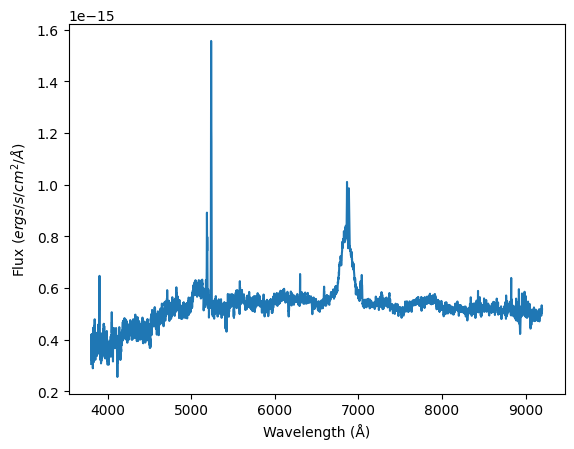

In [10]:
import matplotlib.pyplot as plt

# Plot a spectrum
spec = spec_ndf.iloc[1].coadd_spectrum

plt.plot(spec["wave"], spec["flux"])
plt.xlabel("Wavelength (Å)")
plt.ylabel(r"Flux ($ergs/s/cm^2/Å$)")